In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Mean Shift, Spectral Clustering and Affinity Propagation

Setting up the data with three 'blobs'. Data here will be pre-normalized, understand that with real data normalization is important

In [3]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split

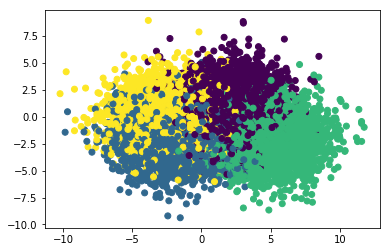

In [20]:
# coordinate centers of blogs
centers = [[2, 1], [-2, -2], [5, -2], [-2.5, 0]]

# 10,000 rows of data with two features. Standard deviation of 1. 3 clusters.
X, Y = make_blobs(n_samples=10000, centers=centers, cluster_std=2,
                 n_features=4, random_state=42)

# make_blobs returns X as samples with n # of features, Y as your labels

plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.show()

In [21]:
# Splitting training and test data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.9, random_state=42)

### What is the Mean Shift algorithm?
K means is sensitive to know how many clusters, what K is, and possibly the initial conditions. K means also assumes circular clumps.

Mean shift seeks 'modes' or local maxima of density in the feature space. The goal is to cluster all the data points in the attraction basin of a mode. Attraction basin: the region for which all trajectories lead to the same mode.

The peaks in this attraction basin become the cluster means. The surface of the probabilities is a 'kernel density surface' Each data point moves toward a cluster mean until they reach these local peaks. Then they are assigned that mean cluster.

Parameters:
* Bandwidth ranged from 0 to 1
- higher bandwidth creates smoother density surface with fewer peaks

Pros:
* No assumptions about how many clusters there will be (unlike K Means)
* Clusters don't have to be the same size. (unlike K Means)
* Outliers too far away from means will not be assigned to a cluser at all. (unlike K means)

Cons:
* Clusters are created around a central point like K Means. Globular clusters.
* Slow, recommended for small to medium-sized datasets only



In [22]:
# Look at mean shift code
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=500)
# The estimate_bandwidth function from sklearn automatically sets based on point distance

meanshift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
meanshift.fit(X_train)

# Extract the clusters
mslabels = meanshift.labels_

# Extract cluster centers
mslabelcenter = meanshift.cluster_centers_

# Count the clusters
n_msclusters_ = len(np.unique(mslabels))

print('Number of clusters: {}'.format(n_msclusters_))

Number of clusters: 2


In [23]:
# Using a crosstab matrix lets see how well it performed.
print(pd.crosstab(y_train, mslabels))

col_0    0   1
row_0         
0      272   1
1      233   6
2      238   0
3      229  21


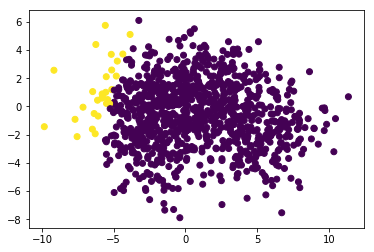

In [25]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=mslabels)
plt.show()

### What is spectral clustering?
Spectral clustering is based on quantifying similarities between data points. Example, piexels in an image that are close by, or part of the same texture. Sometimes people in a social network that share similar category, or words that appear in the same context.

A similarity matrix of n x n dimesion (n being number of datapoints in the dataset) is created. The matrix is then made up of indices of similarity for every pair between points. [Also called affinity matrix]

The similarity matrix is then transformed to calculate a set of eigenvectors (PCA from n x n into nx1) with eigenvalues of each eigenvector. How 'similar' the vectors are to each other cluster these vectors together. PCA the vectors into clusters. Dimensionality is the number of the largest eigenvalues. 3 eigenvalues = 3 dimensions/3 clusters.

Measures of similarity can vary. Nearest neighbors. Gaussian kernel of Euclidean distance (rbf) in sklearn. 0 can mean no similarity and higher numbers are greater similarity.

## Spectral clustering:
### PROS:
* non-globular
* can identify non-flat geometry
### CONS:
* slow
* best when k is not too large
* best when clusters are similarly sized

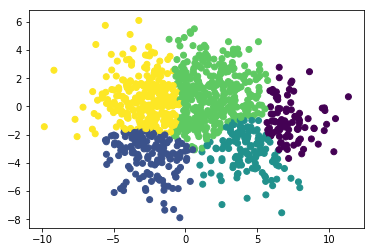

col_0   0    1    2    3    4
row_0                        
0       8    4   14  224   23
1       0  114   12   44   69
2      85    1  108   43    1
3       0   36    1   43  170


In [27]:
from sklearn.cluster import SpectralClustering

# How many clusters are we looking for? we know its 3
n_clusters=5

# Instantiate model
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_train)

# Predict clusters
scpredict = sc.fit_predict(X_train)

# Visualize Results
plt.scatter(X_train[:, 0], X_train[:, 1], c=scpredict)
plt.show()

# Print crosstab matrix to see accuracy
print(pd.crosstab(y_train, scpredict))

### What is Affinity Propagation?

Affinity propagation uses exemplars for data points. An examplar is a data point similar to another data point. They largely convey the same information.

Affinity propagation chooses the number of clusters based on the data nd is often used in imaging. It often seelcts more clusters than other methods so it is suited for data where many clusters are suspected.

It uses a similarity matrix similar to spectral clustering.
Also, however, there is a clustering matrix 'c', also n by n. 

The end goal is to find a matrix composition for c that maximizes net similarity.

PROS:
* Iterates


CONS:
* Slow to run
* Known to overestimate the number of clusters

In [28]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

# Instantiate and fit the model to our training data
af = AffinityPropagation()
af.fit(X_train)

# Find some of the information about the clusters it fit
cluster_centers = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers)
labels = af.labels_

print('Estimated number of clusters is: {}'.format(n_clusters_))

Estimated number of clusters is: 32


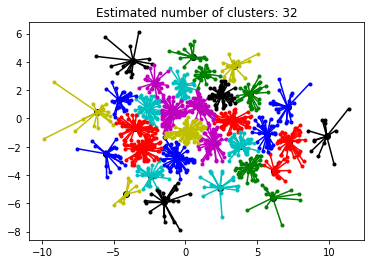

In [29]:
from itertools import cycle

plt.figure(1)
plt.clf()

# Cycle through each cluster and graph them with a center point for the
# exemplar and lines from the exemplar to each data point in the cluster.
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_train[cluster_centers[k]]
    plt.plot(X_train[class_members, 0], X_train[class_members, 1], col + '.')
    plt.plot(cluster_center[0],
             cluster_center[1],
             'o',
             markerfacecolor=col,
             markeredgecolor='k')
    for x in X_train[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: {}'.format(n_clusters_))
plt.show()

After changing the blobs, and having them intermingle with each other, spectral clustering seems to have the best results. Mean-shift had a terrible time handling the blobs that are close to each other, misrepresenting individual blobs into one large one.